# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_1 = pd.read_csv('/datasets/geo_data_0.csv')
data_2 = pd.read_csv('/datasets/geo_data_1.csv')
data_3 = pd.read_csv('/datasets/geo_data_2.csv')

display(data_1.head())
display(data_2.head())
display(data_3.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Проверим на тип данных и наличие пропусков

In [3]:
display(data_1.info())
display(data_2.info())
display(data_3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Как мы видим, наименование одно, а значения абсолютно разные. Из обучения исключим id, т.к. не несет никакой значимости. 

In [4]:
display(data_1.describe())
display(data_2.describe())
display(data_3.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


<AxesSubplot:>

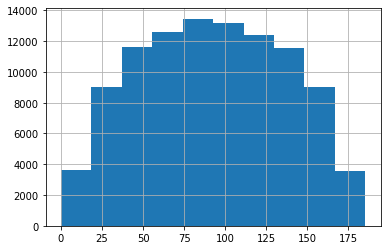

In [5]:
data_1['product'].hist()

<AxesSubplot:>

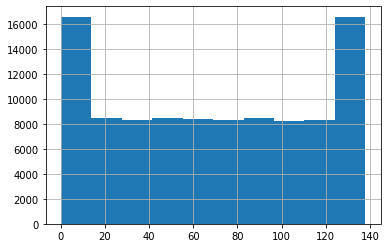

In [6]:
data_2['product'].hist()

<AxesSubplot:>

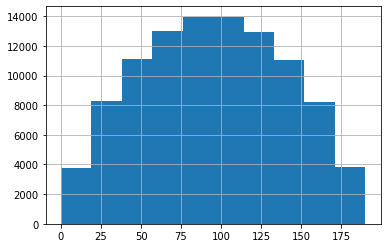

In [7]:
data_3['product'].hist()

Объем запасов в скважине измеряется в тысячи баррелей.

Категориальные признаки отсутствуют, поделим данные на тренировочную и валидационную выборки, сделаем масштабирование данных, для каждого региона по отдельности.

In [10]:
target = data_1['product']
features = data_1.drop(['id','product'], axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)

features_train_1 = features_train.copy()
features_valid_1 = features_valid.copy()
target_train_1 = target_train.copy()
target_valid_1 = target_valid.copy()

numeric = ['f0', 'f1', 'f2']

scaler = StandardScaler()
scaler.fit(features_train_1.loc[:, numeric])
features_train_1.loc[:, numeric] = scaler.transform(features_train_1.loc[:, numeric])
features_valid_1.loc[:, numeric] = scaler.transform(features_valid_1.loc[:, numeric])

In [11]:
target = data_2['product']
features = data_2.drop(['id','product'], axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)

features_train_2 = features_train.copy()
features_valid_2 = features_valid.copy()
target_train_2 = target_train.copy()
target_valid_2 = target_valid.copy()

numeric = ['f0', 'f1', 'f2']

scaler = StandardScaler()
scaler.fit(features_train_2.loc[:, numeric])
features_train_2.loc[:, numeric] = scaler.transform(features_train_2.loc[:, numeric])
features_valid_2.loc[:, numeric] = scaler.transform(features_valid_2.loc[:, numeric])

In [12]:
target = data_3['product']
features = data_3.drop(['id','product'], axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)

features_train_3 = features_train.copy()
features_valid_3 = features_valid.copy()
target_train_3 = target_train.copy()
target_valid_3 = target_valid.copy()

numeric = ['f0', 'f1', 'f2']

scaler = StandardScaler()
scaler.fit(features_train_3.loc[:, numeric])
features_train_3.loc[:, numeric] = scaler.transform(features_train_3.loc[:, numeric])
features_valid_3.loc[:, numeric] = scaler.transform(features_valid_3.loc[:, numeric])

In [20]:
data_1 = data_1.drop('id', axis=1)
data_2 = data_2.drop('id', axis=1)
data_3 = data_3.drop('id', axis=1)

In [21]:
def show_me_hist(data, i):
    data[data.columns.values[i]].hist(bins=50)
    plt.xlabel('count')
    plt.ylabel('frequency')
    plt.title(data.columns.values[i])
    plt.show()

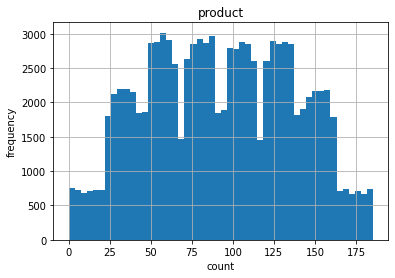

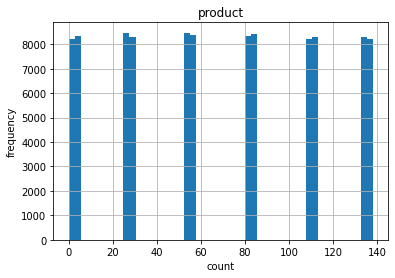

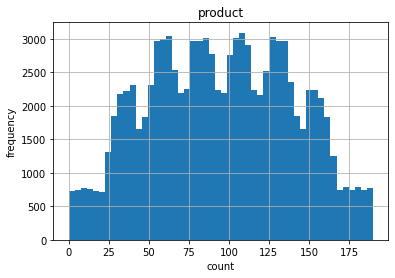

In [22]:
show_me_hist(data_1, 3)
show_me_hist(data_2, 3)
show_me_hist(data_3, 3)

<b>Выводы</b>

- Регион 1 - среднее и медианы равны, распределение нормальное.
- Регион 2 - среднее выше, чем медиана, значит больше скважин с большими значениями. Но значения запасов меньше, чем в регионе 1 и 3.
- Регион 3 - данные такие же как в регионе 1, но запасов чуть больше.

Поделим данные на тренировочную и валидационную выборки, сделаем масштабирование данных, для каждого региона по отдельности.

In [ ]:
target = data_1['product']
features = data_1.drop(['id','product'], axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)

features_train_1 = features_train.copy()
features_valid_1 = features_valid.copy()
target_train_1 = target_train.copy()
target_valid_1 = target_valid.copy()

numeric = ['f0', 'f1', 'f2']

scaler = StandardScaler()
scaler.fit(features_train_1.loc[:, numeric])
features_train_1.loc[:, numeric] = scaler.transform(features_train_1.loc[:, numeric])
features_valid_1.loc[:, numeric] = scaler.transform(features_valid_1.loc[:, numeric])

## Обучение и проверка модели

In [ ]:
rnd = np.random.RandomState(12345)

Выделим целевой признак

In [ ]:
x_1 = data_1.drop('product', axis=1)
y_1 = data_1['product']
x_2 = data_2.drop('product', axis=1)
y_2 = data_2['product']
x_3 = data_3.drop('product', axis=1)
y_3 = data_3['product']

Разобьем выборки на тренировочную и валидационную

In [ ]:
x_train_1, x_valid_1, y_train_1, y_valid_1 = train_test_split(x_1, y_1, test_size=0.25, stratify = y_1, random_state=42)
x_train_2, x_valid_2, y_train_2, y_valid_2 = train_test_split(x_2, y_2, test_size=0.25, stratify = y_2, random_state=42)
x_train_3, x_valid_3, y_train_3, y_valid_3 = train_test_split(x_3, y_3, test_size=0.25, stratify = y_3, random_state=42)

Теперь проверим, как разбились выборки

In [ ]:
print(x_train_1.shape, x_valid_1.shape, y_train_1.shape, y_valid_1.shape)

Далее обучим линейную регрессию на данных трех регионов

In [ ]:
lr_1 = LinearRegression()
lr_2 = LinearRegression()
lr_3 = LinearRegression()
lr_1.fit(x_train_1, y_train_1)
lr_2.fit(x_train_2, y_train_2)
lr_3.fit(x_train_3, y_train_3)

In [ ]:
pred_1 = lr_1.predict(x_valid_1)
pred_2 = lr_2.predict(x_valid_2)
pred_3 = lr_3.predict(x_valid_3)

In [ ]:
pred_1 = pd.Series(pred_1)
pred_2 = pd.Series(pred_2)
pred_3 = pd.Series(pred_3)

In [ ]:
target_1 = y_valid_1.reset_index(drop=True)
target_2 = y_valid_2.reset_index(drop=True)
target_3 = y_valid_3.reset_index(drop=True)

Теперь посмотрим средний запас предсказанного сырья и RMSE для троих моделей

In [ ]:
print('Средний запас предсказанного сырья_1: {:.2f}'.format(pred_1.mean()))
print('RMSE модели_1: {:.2f}'.format(mean_squared_error(target_1, pred_1)**0.5))

print('Средний запас предсказанного сырья_2: {:.2f}'.format(pred_2.mean()))
print('RMSE модели_2: {:.2f}'.format(mean_squared_error(target_2, pred_2)**0.5))

print('Средний запас предсказанного сырья_3: {:.2f}'.format(pred_3.mean()))
print('RMSE модели_3: {:.2f}'.format(mean_squared_error(target_3, pred_3)**0.5))

<b>Выводы</b>

- Средний запас предсказанного сырья практически соответствует средним значениям запасов первоначальных данных.
- Минимальная метрика RMSE обнаружена в регионе № 2, она равна 0.84, хуже всего предсказывает модель региона № 3, метрика равна 39.88.
- Модель № 2, скорее всего, так справилась из-за предварительно сгруппированных данных по запасам (12 подвыборок).

## Подготовка к расчёту прибыли

Расчитаем минимальный запас в скважине для безубыточной разработки месторождения

In [ ]:
budget = 10000000000
price = 450000
profit = budget / 200 / price
billion = 1000000000
print('Объём сырья для безубыточной разработки одной скважины: {:.2f} тыс. баррелей'.format(profit))

In [ ]:
print("Средний истинный запас сырья в регионах, тыс. баррелей:")
print()
count = 0
targets = [target_1, target_2, target_3]
for target in targets:
    count += 1
    print('Регион ', count,': ',  target.mean())

<b>Выводы</b>

- Чтобы получать прибыль, нужно будет выбрать скважины с запасами выше 111.11 тыс.баррелей;
- Средние запасы каждого из регионов меньше необходимого запаса для безубыточной разработки, но ср.кв.ошибка говорит о том, что верные ответы целевого признака имеют большие запасы.

## Расчёт прибыли и рисков 

Создадим функцию по расчету прибыли при разработки лучших скважин

In [ ]:
def profit(target, predict, count):
    predict_sorted = predict.sort_values(ascending=False)
    selected = target[predict_sorted.index][:count]
    return price * selected.sum() - budget

In [ ]:
print('Прибыль региона № 1 (200 лучших скважин): {} млрд.рублей'.format(profit(target_1, pred_1, 200) / billion))
print('Прибыль региона № 2 (200 лучших скважин): {} млрд.рублей'.format(profit(target_2, pred_2, 200) / billion))
print('Прибыль региона № 3 (200 лучших скважин): {} млрд.рублей'.format(profit(target_3, pred_3, 200) / billion))

Как видим, максимальная прибыль у региона № 1

Исходя из условий задачи я исследуем 500 точек, а выберем 200 лучших. Попробуем найти случайные 500 скважин из всей выборки (1000 раз), из них выберем 200 лучших, затем посчитаем среднюю прибыль по всей выборке и по регионам.

In [ ]:
def bootstrap (target, predictions):
    values = []
    for i in range(1000):
        target_subsample = target.reset_index(drop=True).sample(n=500, replace=True, random_state=rnd)
        pred_subsample = predictions[target_subsample.index]
        values.append(profit(target_subsample, pred_subsample, 200))
    risk = 0.025
    values = pd.Series(values)
    lower = values.quantile(risk)
    high = values.quantile(0.975)
    confidence_interval = (lower, high)
    mean = values.mean()

    print("Средняя прибыль региона: {:.2f} млрд.рублей".format(mean / billion))
    print("2,5%-квантиль: {:.2f} млрд.рублей".format(lower / billion))
    print("97,5%-квантиль: {:.2f} млрд.рублей".format(high / billion))
    print("Доверительный интервал: ", confidence_interval)
    print("Риск убытка:", (values < 0).mean())

In [ ]:
bootstrap(target_1, pred_1)

In [ ]:
bootstrap(target_2, pred_2)

In [ ]:
bootstrap(target_3, pred_3)

По совокупности критериев - для скважины лучше всех показал регион № 2.

<b>Выводы</b>

- Большое количество скважин с лучшими запасами имеет регион № 1, который показал прибыль 3.4 млрд рублей на лучших предсказанных данных.
- Но выбирать регион только по лучшей прибыли некорректно, т.к. надо рассматривать и риски и расходы, особенно, когда на разработку нужно потратить 10 млрд рублей.
- Основной критерий - вероятность убытков - 2.5 %. Регион № 2 имеет самую низкую вероятность убытков, всего 0.5%. И более узкий доверительный интервал, и соответственно более высокую среднюю прибыль.
- Остальные регионы имеют риск, превышающий основной критерий, поэтому рассмотрены быть не могут, хотя регион № 3 имеет более высокие значения верхней границы доверительного интервала.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован